# Content
- [Interesting findings](#finding)
    * [PCA Kmeans](#PCA)
    * [oracle weight](#weights)
    * [oracle partition](#partition)
    
- [Reproduce plots](#plots)
    * [Simulation 1](#sim1)
    * [Simulation 2](#sim2)
    * [Simulation 3](#sim3)

<a id=finding /a>

# Some interesting issues to clarify.

<a id=PCA>
### PCA Kmeans
</a>
 - How to select the number of principle patterns in PCA Kmeans is an important problem. My intuition is to look at the score of each principle component. You hope to select components with big variance and there should be a gap between the selected and the dropped.
 - I found for this case, it will be a pretty good fit when I do cutoff on the first principle pattern.

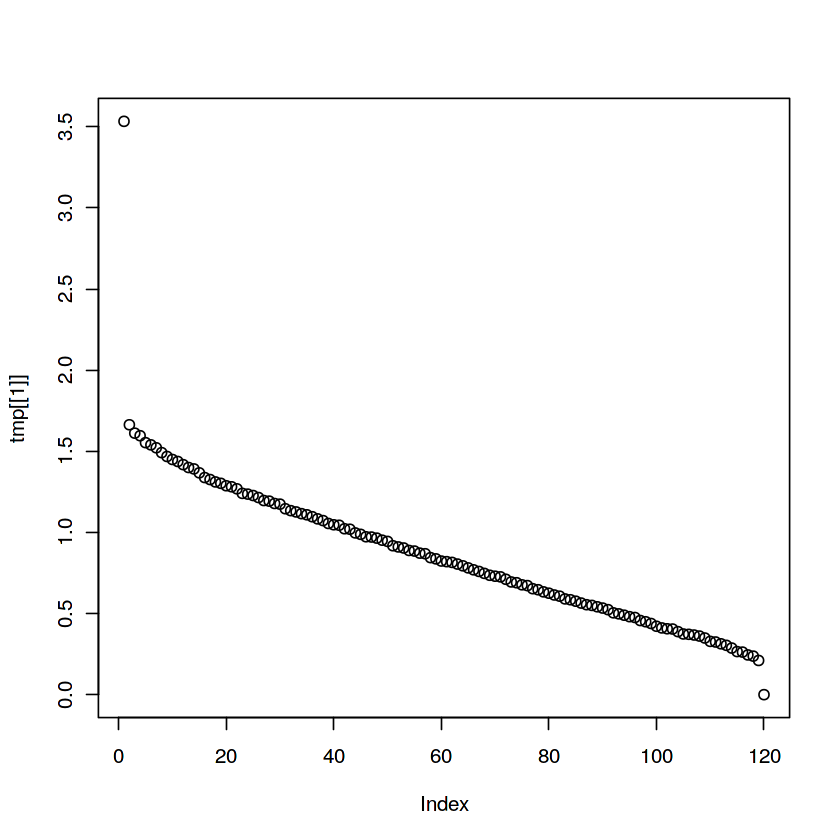

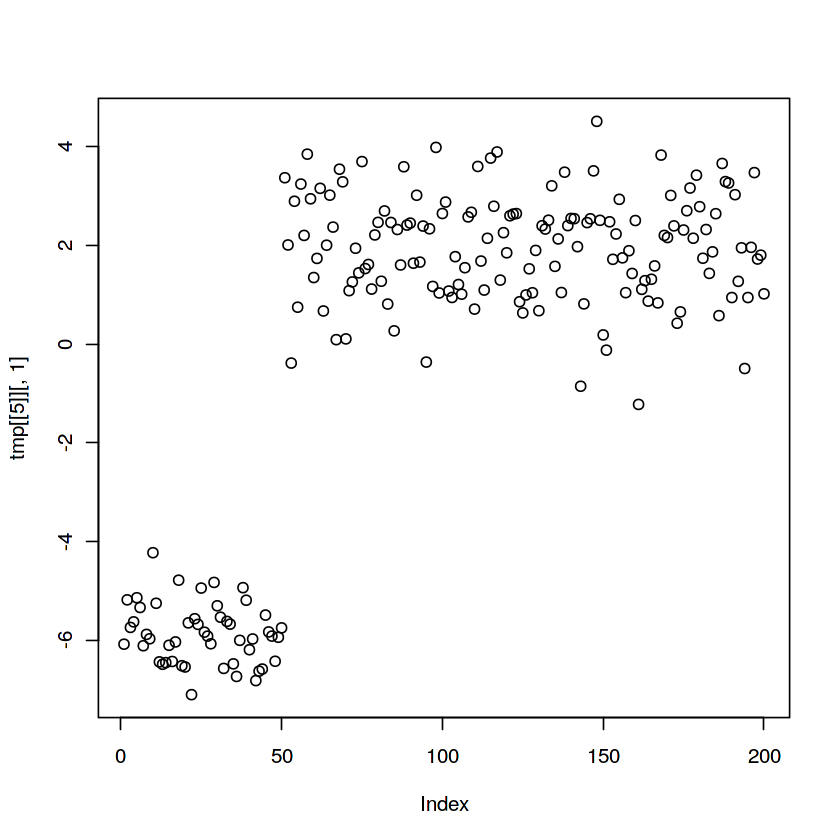

In [2]:
# Code to illustrate
load('2016-10-04-12-57-16-info-1.RData')
data = info[1, 1, 1][[1]][[1]]
tmp = prcomp(t(data))
plot(tmp[[1]])
plot(tmp[[5]][,1])
# For this scenario, we should choose the first one.

<a id=weights>
### Oracle feature weight for k means
</a>
 - Intuitively, the feature weight shall be assigned to maximize the L2 difference between centers of each cluster (Not very accurate though because you also need to consider the variance/shape of each cluster)

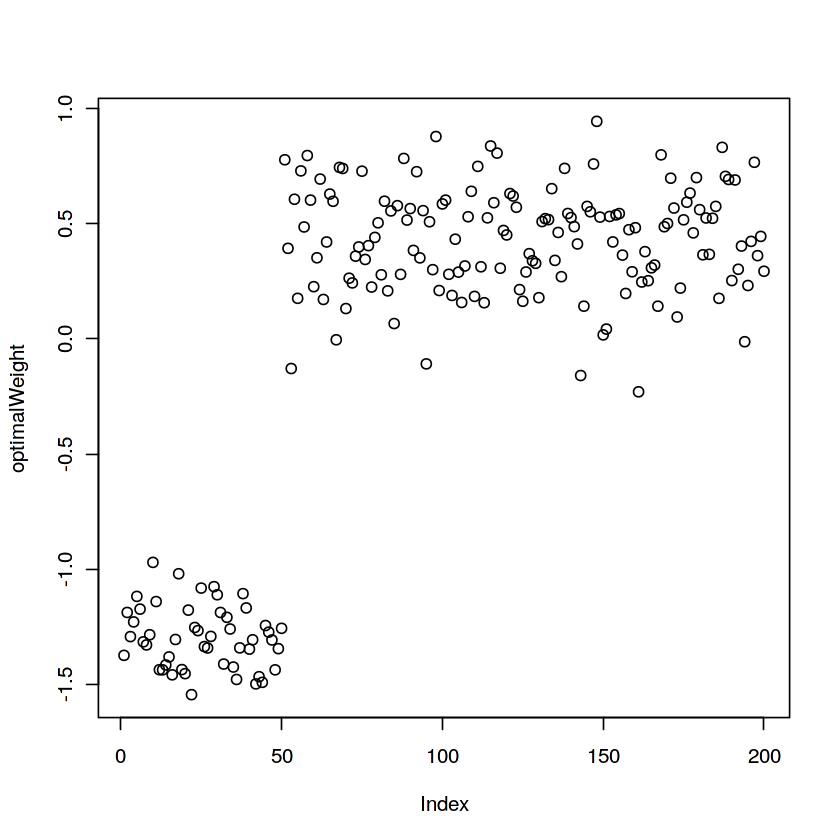

In [3]:
centers = matrix(0, nrow = 6, ncol = 200)
for(i in 1:6){
    centers[i,] <- apply(data[(20*(i-1) + 1):(20*i),], 2, mean)
}
# Use sample mean seems too noisy, so I plan to switch to use expection (model parameter)
optimalWeight <- prcomp(t(centers))[[5]][,1]
plot(optimalWeight)

<a id=partition>
### Oracle Partition
</a>
  - One thing needs to worry about using cluster labels is that they can be too "impractical", for example when some samples are very close to other centers, there is no way to get this label correct. One way to solve this issue is to consider use kmeans with good initial (true label) and adjusted feature weights (no noise feature and fine tuned relevant features)

<a id=plots>
# Reproduce the plot
</a>
* Need to have Rdata files.

In [8]:
# This section submit the experiment code to the server
system('qsub -pe smp 12 -q high.q run.sh')

In [4]:
library(repr)
options(repr.plot.height = 4, repr.plot.width = 12) # Adjust plot size in jupyter
# Generate plots using output file from experiments
CER<- function (partition1=NULL,partition2=NULL){
  if (length(partition1)!= length(partition2))
    stop("partition1 and 2 don't have the same observations")
  mycer<-0;
  for (i in 1:(length(partition1)-1)){
    for (j in (i+1):length(partition1)){
      mycer<- mycer + abs((partition1[i]==partition1[j])-(partition2[i]==partition2[j])    )  
    }
  }
  mycer<- mycer/(length(partition1)*(length(partition1)-1)/2)
  return(mycer)
}
MakeBoxplot <- function(result, 
                        ylim = c(0,1), 
                        mus  = c(0.6, 0.7),
                        alg.names,
                        color.min = 1){
  # boxplot for simulaiotn 1 in sparse clustering paper
  par(mfrow = c(1,3), mai = c(.8, .8, .1, .1))
  mat <- result[, 1, 1, ]
  ylab <- as.formula(paste('mu ~ "=" ~ ',mus[1]))
  meds <- apply(mat, 2, median)
  colors <- c(0, 0, 0, 0, 0)
  if (color.min) {
      colors[which.min(meds)] <- 2
  } else {
      colors[which.max(meds)] <- 2
  }
  boxplot(mat, col = colors, 
          boxwex = 0.4, ylab = as.expression(ylab), 
          ylim = ylim,
          names = alg.names)
  
  mat <- result[, 2, 1, ]
  meds <- apply(mat, 2, median)
  colors <- c(0, 0, 0, 0, 0)
  if (color.min) {
      colors[which.min(meds)] <- 2
  } else {
      colors[which.max(meds)] <- 2
  }
  boxplot(mat, col = colors, 
          ylim = ylim,
          boxwex = 0.4, names = alg.names)
  
  mat <- result[, 3, 1, ]
  meds <- apply(mat, 2, median)
  colors <- c(0, 0, 0, 0, 0)
  if (color.min) {
      colors[which.min(meds)] <- 2
  } else {
      colors[which.max(meds)] <- 2
  }
  boxplot(mat, col = colors,
          ylim = ylim,
          boxwex = 0.4, names = alg.names)
  
  
  par(mfrow = c(1, 3), mai = c(.8, .8, .1, .1))
  mat <- result[, 1, 2, ]
  meds <- apply(mat, 2, median)
  colors <- c(0, 0, 0, 0, 0)
  if (color.min) {
      colors[which.min(meds)] <- 2
  } else {
      colors[which.max(meds)] <- 2
  }
  ylab <- as.formula(paste('mu ~ "=" ~ ',mus[2]))
  boxplot(mat, col = colors,
          boxwex = 0.4, xlab = "p = 200",
          ylab = as.expression(ylab),
          ylim = ylim,
          names = alg.names)
  
  mat <- result[, 2, 2, ]
  meds <- apply(mat, 2, median)
  colors <- c(0, 0, 0, 0, 0)
  if (color.min) {
      colors[which.min(meds)] <- 2
  } else {
      colors[which.max(meds)] <- 2
  }
  boxplot(mat,col=colors,
          boxwex = 0.4, xlab = "p = 500",
          ylim = ylim,
          names=alg.names)
  
  mat <- result[, 3, 2, ]
  meds <- apply(mat, 2, median)
  colors <- c(0, 0, 0, 0, 0)
  if (color.min) {
      colors[which.min(meds)] <- 2
  } else {
      colors[which.max(meds)] <- 2
  }
  boxplot(mat, col = colors,
          boxwex = 0.4, xlab = "p = 1000",
          ylim = ylim,
          names = alg.names)
}

<a id=sim1>
## Simulation 1 plot
</a>

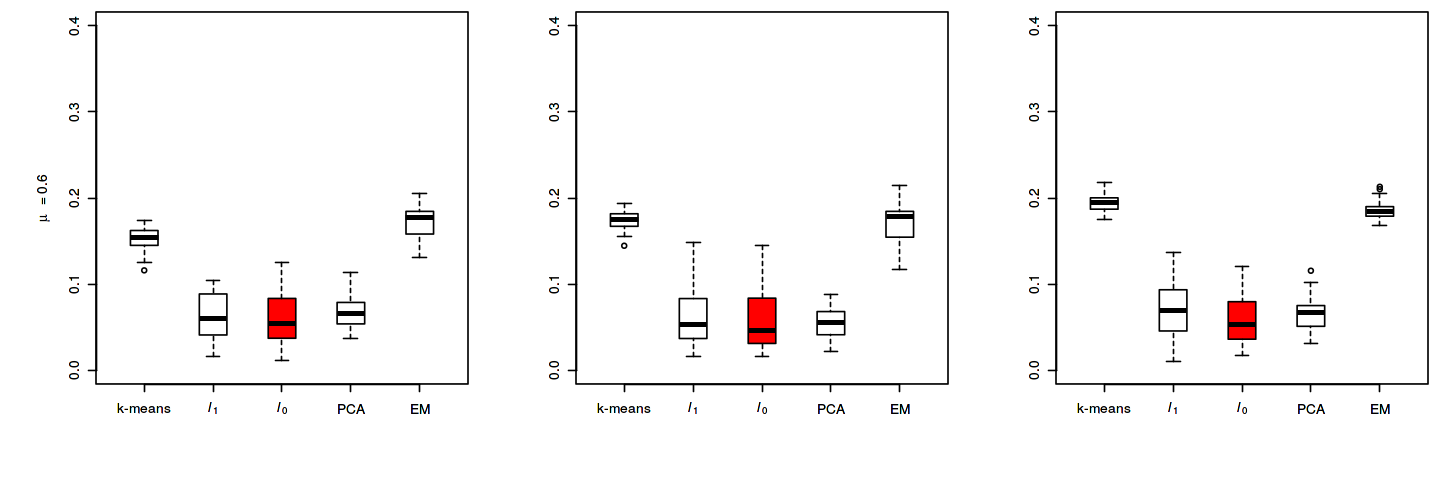

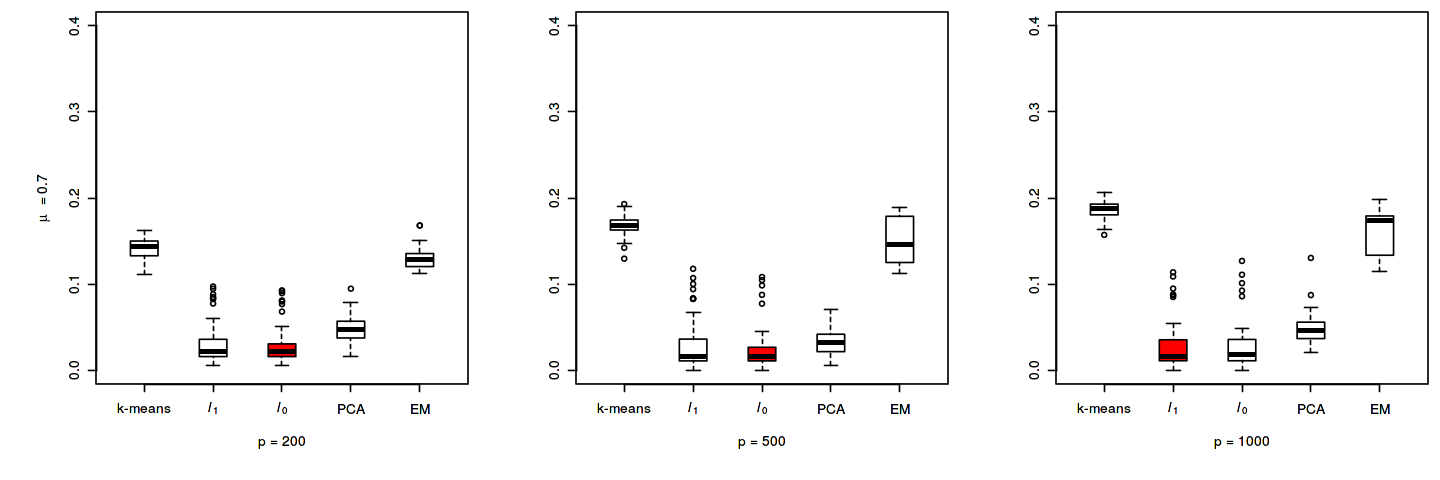

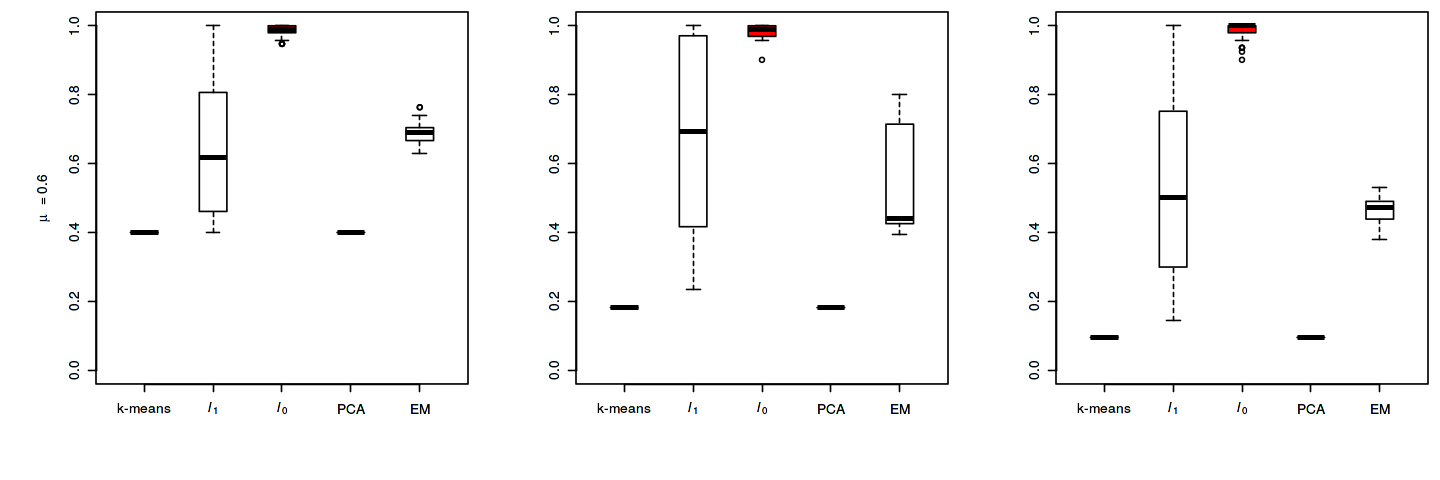

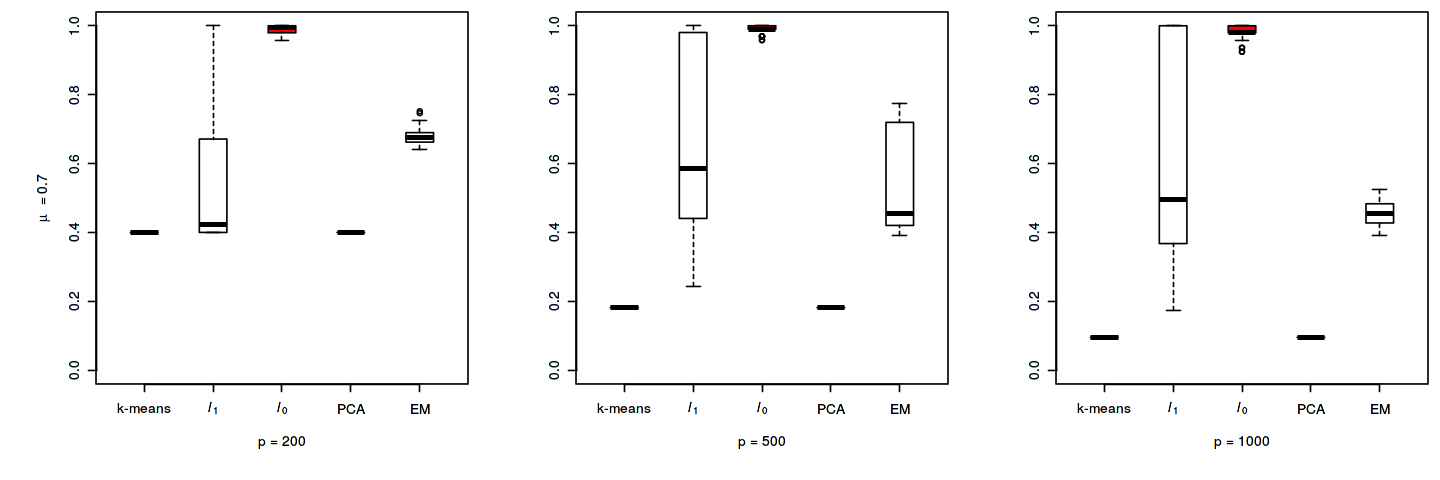

In [5]:
load('2016-10-04-16-40-13-info-2.RData') # simulation 1
num.iter <- dim(info)[1]
num.feature <- dim(info)[2]
num.mus <- dim(info)[3]
num.alg <- length(info[1,1,1][[1]]$results)
result.cer <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.recall <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.precision <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.Fscore <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
true.label <- rep(1:6,rep(20,6))
for (i1 in 1:num.iter)
  for (i2 in 1:num.feature)
    for (i3 in 1:num.mus)
      for (i4 in 1:num.alg) {
        tmp <- info[i1, i2, i3][[1]]
        result.cer[i1, i2, i3, i4] <- CER(true.label,tmp$results[[i4]]$Cs) 
        result.recall[i1, i2, i3, i4] <- sum(tmp$results[[i4]]$weights[1:50] != 0)/50
        result.precision[i1, i2, i3, i4] <- sum(tmp$results[[i4]]$weights[1:50] != 0)/sum(tmp$results[[i4]]$weights != 0)
        result.Fscore[i1, i2, i3, i4] <- 2/(result.precision[i1, i2, i3, i4]^-1 + result.recall[i1, i2, i3, i4]^-1)
      }
alg.names <- c("k-means",expression(italic(l)["1"]),expression(italic(l)["0"]), "PCA", "EM")
MakeBoxplot(result.cer, 
            ylim = c(0, 0.4),
            mus = c(0.6, 0.7),
            alg.names,
            color.min = 1)
MakeBoxplot(result.Fscore, 
            ylim = c(0, 1),
            mus = c(0.6, 0.7),
            alg.names, 
            color.min = 0)

<a id=sim2>
## Simulation 2 plot
</a>

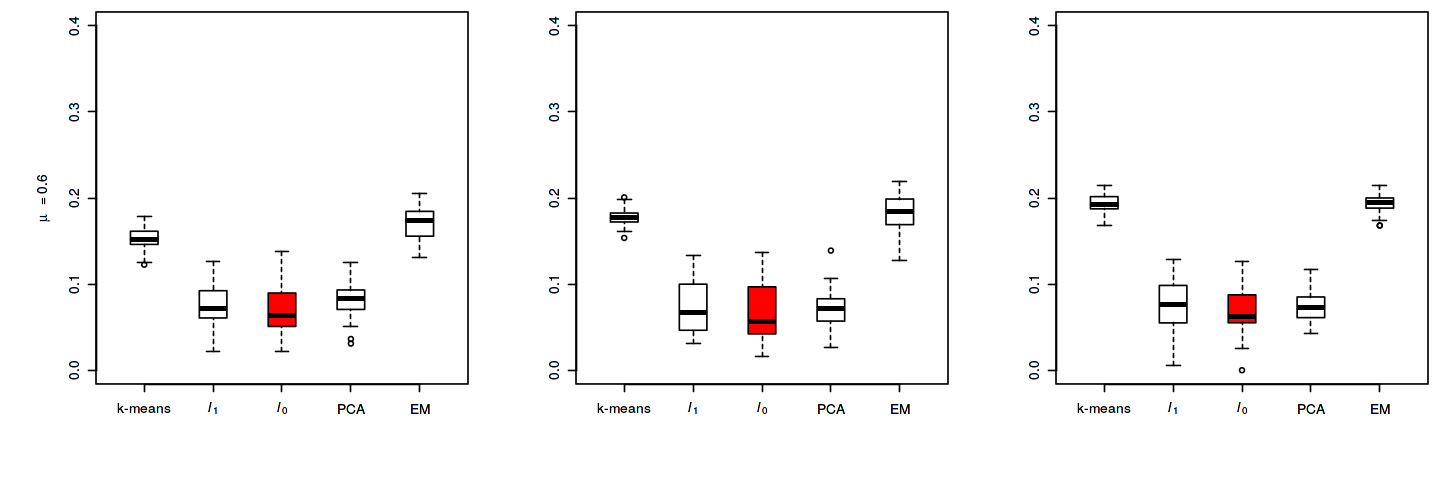

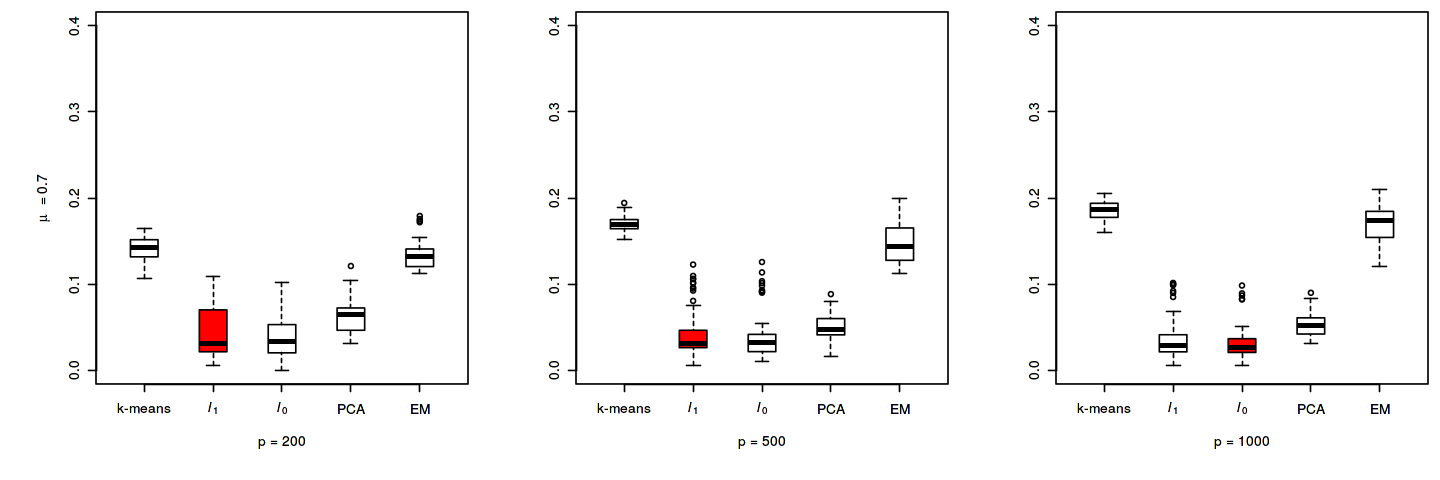

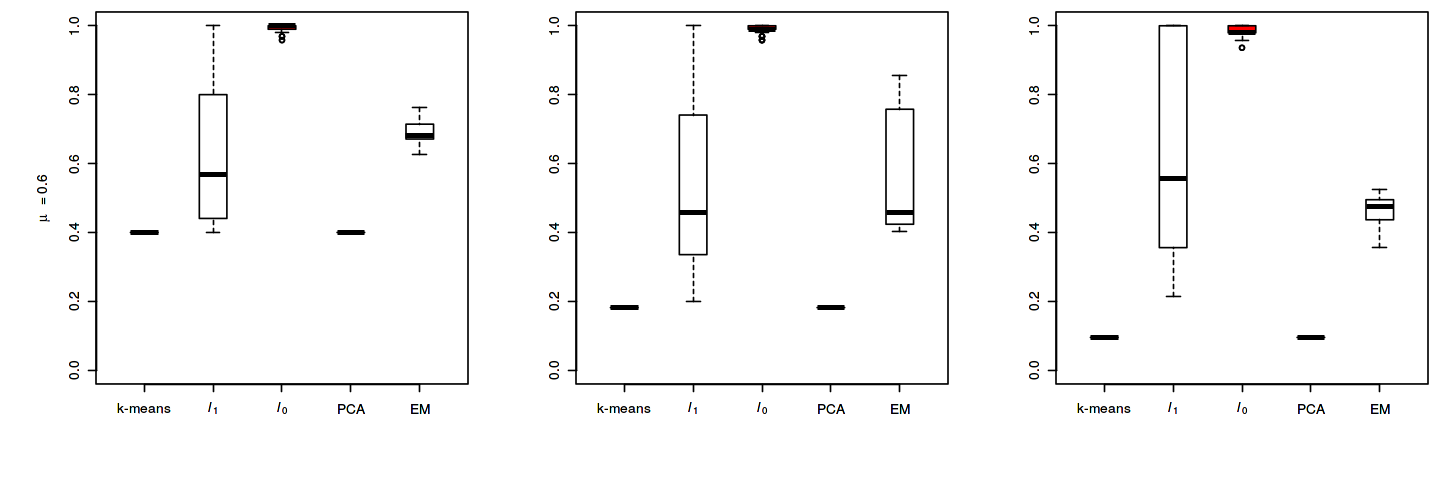

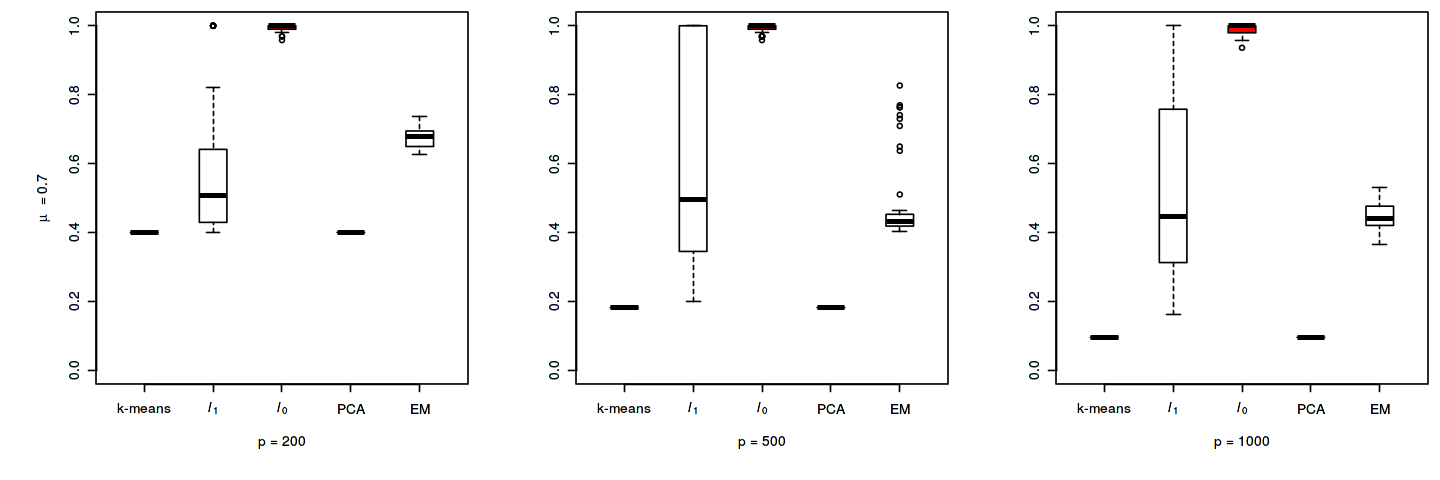

In [3]:
load('./2016-10-05-02-15-58-info-2.RData') # simulation 2
num.iter <- dim(info)[1]
num.feature <- dim(info)[2]
num.mus <- dim(info)[3]
num.alg <- length(info[1,1,1][[1]]$results)
result.cer <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.recall <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.precision <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.Fscore <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
true.label <- rep(1:6,rep(20,6))
for (i1 in 1:num.iter)
  for (i2 in 1:num.feature)
    for (i3 in 1:num.mus)
      for (i4 in 1:num.alg) {
        tmp <- info[i1, i2, i3][[1]]
        result.cer[i1, i2, i3, i4] <- CER(true.label,tmp$results[[i4]]$Cs) 
        result.recall[i1, i2, i3, i4] <- sum(tmp$results[[i4]]$weights[1:50] != 0)/50
        result.precision[i1, i2, i3, i4] <- sum(tmp$results[[i4]]$weights[1:50] != 0)/sum(tmp$results[[i4]]$weights != 0)
        result.Fscore[i1, i2, i3, i4] <- 2/(result.precision[i1, i2, i3, i4]^-1 + result.recall[i1, i2, i3, i4]^-1)
      }
alg.names <- c("k-means",expression(italic(l)["1"]),expression(italic(l)["0"]), "PCA", "EM")
MakeBoxplot(result.cer, 
            ylim = c(0, 0.4),
            mus = c(0.6, 0.7),
            alg.names,
            color.min = 1)
MakeBoxplot(result.Fscore, 
            ylim = c(0, 1),
            mus = c(0.6, 0.7),
            alg.names,
            color.min = 0)

<a id=sim3>
## Simulation 3 plot
</a>

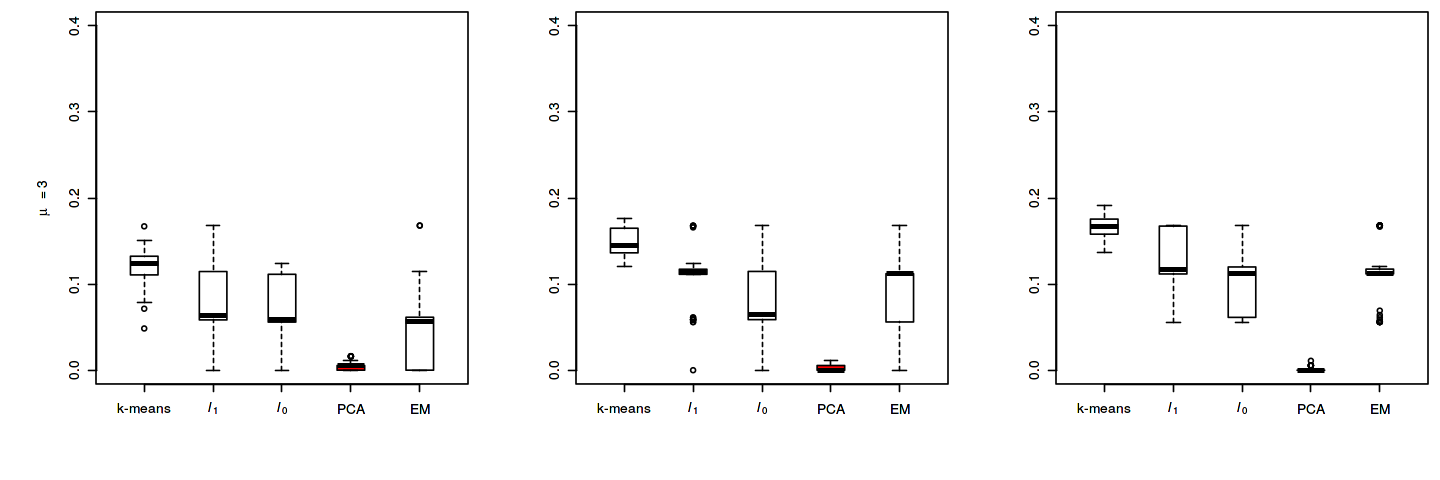

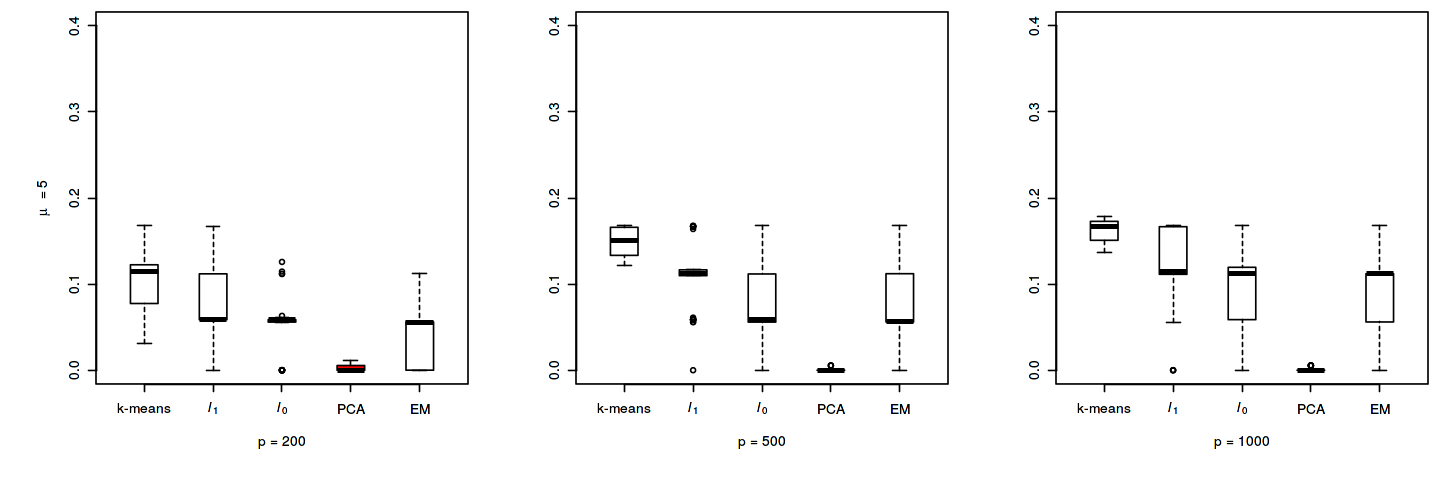

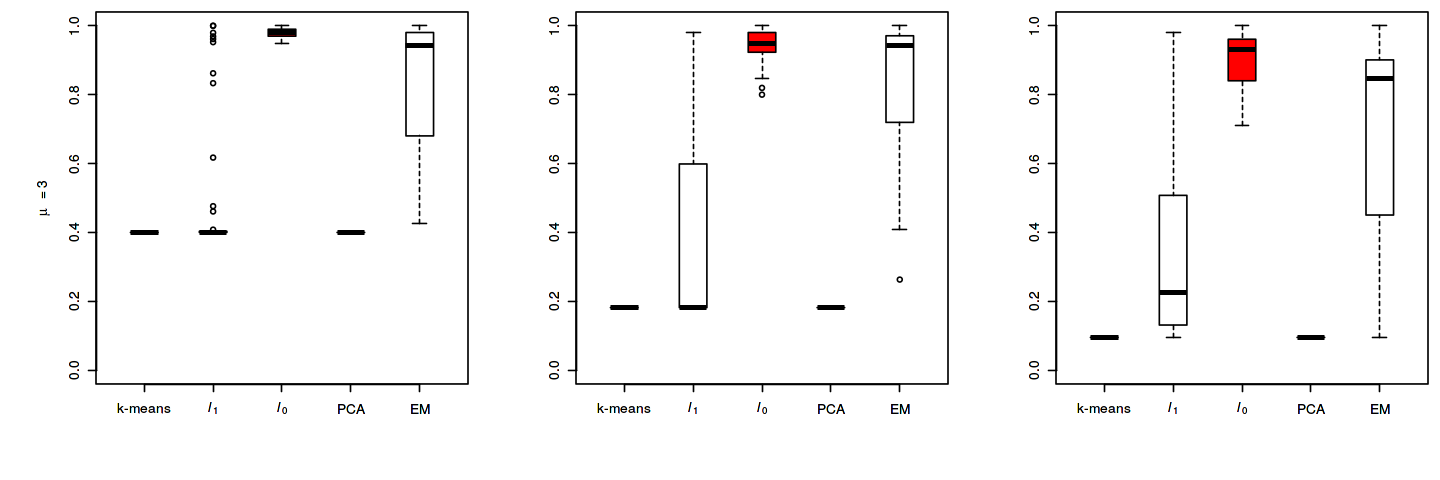

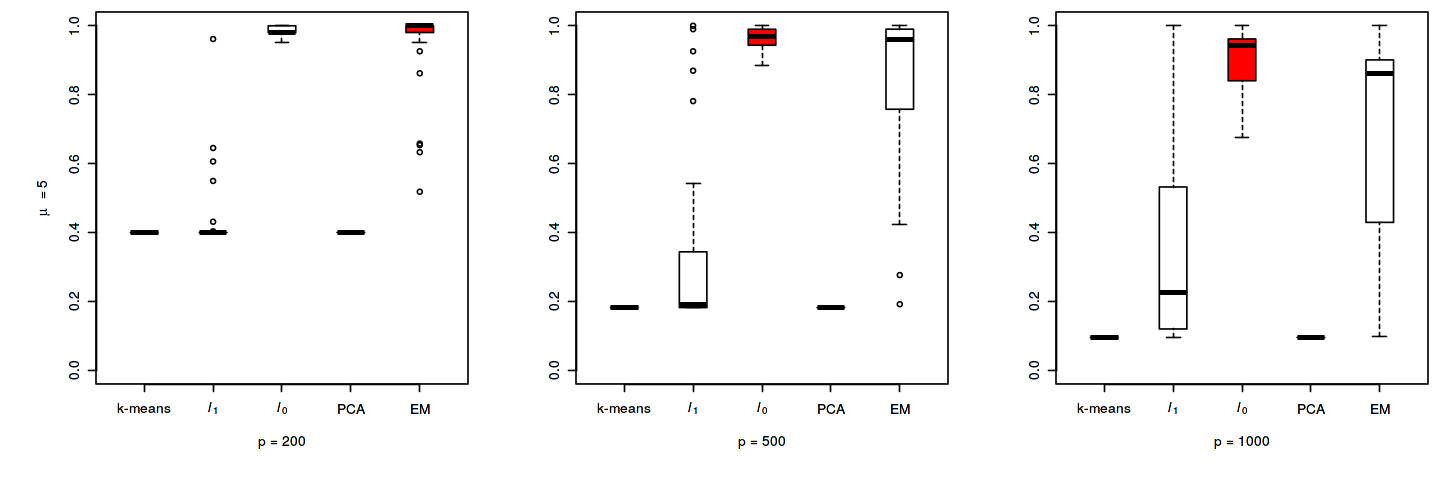

In [7]:
load('2016-10-05-09-47-38-info-2.RData') # simulation 3
num.iter <- dim(info)[1]
num.feature <- dim(info)[2]
num.mus <- dim(info)[3]
num.alg <- length(info[1,1,1][[1]]$results)
result.cer <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.recall <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.precision <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
result.Fscore <- array(NA, dim = c(num.iter, num.feature, num.mus, num.alg))
true.label <- rep(1:6,rep(20,6))
for (i1 in 1:num.iter)
  for (i2 in 1:num.feature)
    for (i3 in 1:num.mus)
      for (i4 in 1:num.alg) {
        tmp <- info[i1, i2, i3][[1]]
        result.cer[i1, i2, i3, i4] <- CER(true.label,tmp$results[[i4]]$Cs) 
        result.recall[i1, i2, i3, i4] <- sum(tmp$results[[i4]]$weights[1:50] != 0)/50
        result.precision[i1, i2, i3, i4] <- sum(tmp$results[[i4]]$weights[1:50] != 0)/sum(tmp$results[[i4]]$weights != 0)
        result.Fscore[i1, i2, i3, i4] <- 2/(result.precision[i1, i2, i3, i4]^-1 + result.recall[i1, i2, i3, i4]^-1)
      }
alg.names <- c("k-means",expression(italic(l)["1"]),expression(italic(l)["0"]), "PCA", "EM")
MakeBoxplot(result.cer, 
            ylim = c(0, 0.4),
            mus = c(3, 5),
            alg.names,
            color.min = 1)
MakeBoxplot(result.Fscore, 
            ylim = c(0, 1),
            mus = c(3, 5),
            alg.names,
            color.min = 0)

In [4]:
give.data <- function (SamplesPerCluster = 20,
                       Nfeatures = 50,
                       Nsignals = 10,
                       ClusterNumber = 3, mu = 1) {
  x <- matrix(rnorm(Nfeatures*SamplesPerCluster*ClusterNumber),ncol=Nfeatures)
  for (i in 1:ClusterNumber){
    tmp <- matrix(1, nrow = SamplesPerCluster, ncol = 1) %*% matrix(0.75 + 0.5*runif(Nsignals),ncol = Nsignals, nrow = 1) 
    x[(SamplesPerCluster*(i-1)+1):(SamplesPerCluster*i),1:Nsignals] <- x[(SamplesPerCluster*(i-1)+1):(SamplesPerCluster*i),1:Nsignals] * tmp +(i-2)*mu
  }
  # x <- scale(x, TRUE, TRUE)
  return(x)
}


a = give.data(2, 7, 2, 3, 1000)
a # this indicate a fatal bug in Exp1

-1.001022e+03,-1000.0282267,0.2387375,-0.31108300,-0.1290302,-1.0753523,-1.21444731
-1.000773e+03,-999.8970135,-0.4960565,0.06024977,-0.5837407,0.0420828,0.94217285
-6.612679e-01,0.7852755,-1.2298480,-0.32658837,-1.4157069,-1.0095426,0.55295789
-5.778824e-02,0.4014982,0.3574183,-0.50284973,1.0310733,-0.9927040,0.37988110
1.000812e+03,1000.2002688,-0.5323142,-0.03962069,-0.7849650,1.0691810,0.55433381
1.002036e+03,1000.7461158,-1.0716141,-2.27863067,2.8508417,0.9225964,0.02480979
